# DETERMINE CORRECT FLIP/ROTATION OF GAIN IMAGE

#### Requirements
1) Input movies are TIFF
2) Input gain is MRC
3) GAIN and movies have same dimensions
4) Subsequent work in in cryosparc. (I think for relion a additional y-flip is required)

#### Hypothesis: 
1) If the gain is correctly applied to individual images when they are averaged together, they will be flat (low variance) as the underlying defects are reversed. 
2) The running average of the movie frames (= gain from data) should converge to be most similar to a provided gain that is correctly transformed.

#### Method: 
1) READ in frames and as the frames are added, they are multiplied with the GAIN image (but with different transformations). These gain correct frames are then avaraged and the final average is viewed to determine which gain transformation is giving the best correction (i.e yields flatest image).
2) The calculated gain (recipricol of the running average of frames) is compared to the provided transfomed gain (i.e. none, flipud, fliplr, rot180) using the structural simularity index, and the transformation that is most similar indicates how the provided gain has been transformed.


#### Assaying gain correction
1) Compare Visually:  look at the final gain corrected running average. Expect a flat image
2) Compare Standard Deviation (Std Dev) or median absolute deviation (MAD) in gain corrected running average. Expect the gain correct image to have lower varience than the non-gain corrected. Also, a wrong gain should increase variance as we impose a 2nd artificial pattern.
3) Compare the running average (not gain corrected) to the transformed gains using the Structural Similarity index (SSIM). Expect the running average (reciprocal) to converge to the correct gain image and be less similar to the wrong gain images.

#### Notes on method
1) According to this post https://groups.google.com/g/warp-em/c/-fOnQ34VMO8/m/g8d6C8T6AwAJ K2/K3 gains are multiplied to the raw images
2) According to this post (not sure I understand), flipping and rotating gain is required because camera can be installed in several orientations https://discuss.cryosparc.com/t/flipping-and-rotating-gain-reference/9877/5?u=frozenfas
3) According to this post, file.imread() opens tiffs like cryosparc https://discuss.cryosparc.com/t/cryosparc-tools-open-tiff/13255/6?u=frozenfas
4) According to this post, RELION/Motioncoor read tiff differently (flipY), accounting for the need to flip differently if you are using RELION/Motioncoor or CS https://discuss.cryosparc.com/t/flipping-and-rotating-gain-reference/9877/2?u=frozenfas
NOTE: The notebook I used in the test is here.  This code is not well organised. it would be better to organise it in 3D arrays to make it cleaner.  Also, see notes, but there are several places to make it more efficient, but it is mostly i/o limited, so I am not so worried.

In [1]:
# **************************************************************************
# *
# * Authors:    Sean Connell (sean.connell@gmail.com)
# *
# * Structural Biology of Cellular Machines
# *
# **************************************************************************

# check transformation to apply to gain in CS

In [2]:
#import starfile
import mrcfile
import pandas as pd
import argparse
import os, glob, re
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tifffile # confirmed by CS-team this is same orientation as CS
import ncempy.io as nio
from ncempy.algo import rebin 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

#https://scikit-image.org/docs/stable/api/skimage.metrics.html#

/tmp/ipykernel_148506/3779422901.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# input file name 
glob_file = 'DATA/raw/GridSquare_3324686/Data/*_fractions.tiff'
n_mics = 250                     # number of movies to average. 
# TODO: there is a error in the size of stat array if number of mics is not divisible by update freq
update_freq = 10                 # update stats on the running average every x iterations
fnMrcGain = 'gain.mrc'


mic_list = glob.glob(glob_file)
print(f'{len(mic_list)} movies have been found at provide path')
if len(mic_list) < n_mics:
    print(f'Number of movies requested is greater tham number of movies found setting movies to {len(mic_list)} ')
    n_mics = len(mic_list)



1125 movies have been found at provide path


In [4]:
# read in files and modify/flip as required
MrcGain = mrcfile.open(fnMrcGain, mode='r+') # unmodified  gain (just bined and converted as discribed above)
DataGain = MrcGain.data
del MrcGain

#print(DataGain.shape)
GainNRows, GainNCols = DataGain.shape
print(f'The provided gain dimenions: {GainNRows}, {GainNCols}')

# tranform gain
DataGainflr = np.fliplr(DataGain) #  gain left right flip ( =x = flipped columns)
DataGainfud = np.flipud(DataGain) # gain up down flip ( =y = flipped rows )
DataGainrot = np.rot90(np.rot90(DataGain)) # gain rotate 180 same as both fliplr and flipud

# I dont think rot90 or rot270 are valid as the K3 sensor is rectangular and I can see that the gain  
# is in same orintation as movies

# test read tiff to see dimensions
a = tifffile.imread(mic_list[0])
n_frames,TiffNRows,TiffNCols = a.data.shape

print(f'The tiff movie dimenions: {TiffNRows}, {TiffNCols}')
print(f'The tiff movie frames: {n_frames}')
print('Do not proceed if dimensions are not equal')

The provided gain dimenions: 4092, 5760
The tiff movie dimenions: 4092, 5760
The tiff movie frames: 49
Do not proceed if dimensions are not equal


In [5]:
# MAD = median absolute deviation https://stackoverflow.com/questions/60092641/mad-results-differ-in-pandas-scipy-and-numpy
# less senstenve to outliers than std
def get_stats(a):
    m = np.mean(a)
    std = np.std(a)
    mad = np.median(np.absolute(a - np.median(a)))
    return m, std, mad
def get_ssim(im_avg,im_gain):
    ssim_vs_avg = ssim(im_gain, im_avg, data_range=im_avg.max() - im_avg.min())
    return ssim_vs_avg


# initialize zero array to accumilate running sum of frames  
# use float64. I get wrap around errors if  I use float32
# if I save to MRC remember to use .astype(np.float32)
array_none = np.zeros(shape=(GainNRows, GainNCols), dtype=np.float64)
array_gain = np.zeros(shape=(GainNRows, GainNCols), dtype=np.float64)
array_gainflr = np.zeros(shape=(GainNRows, GainNCols), dtype=np.float64)
array_gainfud = np.zeros(shape=(GainNRows, GainNCols), dtype=np.float64)
array_gainrot = np.zeros(shape=(GainNRows, GainNCols), dtype=np.float64)

# initialize zero array to store statistics every n-iterations
# ncol=21 becasue we store n_movie, n_frames, and (mean, std and mad) for each gain (= 15)
# nrow is the quotient from the number of movies diveded by the update freq
array_stats = np.zeros(shape=(n_mics // update_freq, 21)) 
update_counter = 0

for i in tqdm.tqdm(range(n_mics)):
    #print(mic_list[i])
    # print(i)
    a = tifffile.imread(mic_list[i])
    # note Sean it is ineficent this loop it would be better to add all frames then mulitiply
    # becasue x(a+b) = ax+bx.  Better luck next time
    for f in range(n_frames):
        #print(i,f)
        array_none += a[f]
        array_gain += (a[f]* DataGain)
        array_gainflr += (a[f] * DataGainflr )
        array_gainfud += (a[f] * DataGainfud )
        array_gainrot += (a[f] * DataGainrot )
    if ((i+1) % update_freq == 0): # will update every iteraction that is divible by 10 (10,20,30 movie)
        t = (i+1) * n_frames
        # the arrays are the running total, therefore divide by number of frames to get current average
        m_none, std_none, mad_none = get_stats(array_none / t)
        m_gain, std_gain, mad_gain = get_stats(array_gain / t)
        m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr / t)
        m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud / t)
        m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot / t)
        # compare running average to orginal gain
        # I expect the running average to get more similar to the correct gain as more
        # movies are added

        # the running average is the recipricol of a multiplative gain so we switch 
        calculatedGain = np.reciprocal((array_none / t))
        
        ssim_gain = get_ssim(calculatedGain, DataGain)
        ssim_gainflr = get_ssim(calculatedGain, DataGainflr)
        ssim_gainfud = get_ssim(calculatedGain, DataGainfud)
        ssim_gainrot = get_ssim(calculatedGain, DataGainrot)

        #print(ssim_gain)
        
        # strore the stats
        array_stats[update_counter]= [i+1, t, m_none, std_none, mad_none, \
                         m_gain, std_gain, mad_gain, ssim_gain, \
                         m_gainflr, std_gainflr, mad_gainflr, ssim_gainflr, \
                         m_gainfud, std_gainfud, mad_gainfud, ssim_gainfud, \
                         m_gainrot, std_gainrot, mad_gainrot, ssim_gainrot ]
        update_counter += 1


# the arrays are the running total, therefore divide by number of frames to get average
t = n_mics*n_frames
array_none /= t
array_gain /= t
array_gainflr /= t
array_gainfud /= t
array_gainrot /= t       


100%|████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [37:51<00:00,  9.09s/it]


Simularity Measure
 GAIN (SSIM): 0.20737811695445288
 GAINFLR (SSIM): 0.20734332110300457
 GAINFUD (SSIM): 0.2173772056712453
 GAINROT (SSIM): 0.2073745273172259


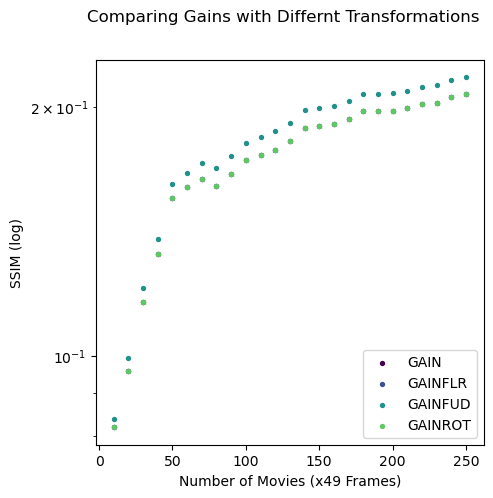

In [7]:
# print out final stats. it should be the similar as those stored in array_states but maybe not the same 
# the number of movies might not be a perfect multiple of the update freq (who is the sick freak who uses a wierd number of movies)
m_none, std_none, mad_none = get_stats(array_none )
m_gain, std_gain, mad_gain = get_stats(array_gain )
m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr )
m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud )
m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot )

calculatedGain = np.reciprocal(array_none)

ssim_gain = get_ssim(calculatedGain ,DataGain)
ssim_gainflr = get_ssim(calculatedGain, DataGainflr)
ssim_gainfud = get_ssim(calculatedGain, DataGainfud)
ssim_gainrot = get_ssim(calculatedGain, DataGainrot)

#NOTE I dont variation measures as the SSIM appears better 

#print('Variation Measure')
#print(f' NONE (m/std): {m_none}, {std_none}' )
#print(f' GAIN (m/std): {m_gain}, {std_gain}' )
#print(f' GAINFLR (m/std): {m_gainflr}, {std_gainflr}' )
#print(f' GAINFUD (m/std): {m_gainfud}, {std_gainfud}' )
#print(f' GAINROT (m/std): {m_gainrot}, {std_gainrot}' )
print('Simularity Measure')
print(f' GAIN (SSIM): {ssim_gain}' )
print(f' GAINFLR (SSIM): {ssim_gainflr}' )
print(f' GAINFUD (SSIM): {ssim_gainfud}' )
print(f' GAINROT (SSIM): {ssim_gainrot}' )


# colormaps = https://matplotlib.org/stable/gallery/color/colormap_reference.html
n = 5
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(5,5)) #sharey=True
fig.suptitle('Comparing Gains with Differnt Transformations')
axs.set_xlabel(f'Number of Movies (x{n_frames} Frames)')
axs.set_ylabel('SSIM (log)')
axs.set_yscale("log")
axs.scatter(x=array_stats[0:, 0], y=array_stats[0:, 8], label='GAIN', s=8, color=colors[0])
axs.scatter(x=array_stats[0:, 0], y=array_stats[0:, 12], label='GAINFLR',s=8, color=colors[1])
axs.scatter(x=array_stats[0:, 0], y=array_stats[0:, 16], label='GAINFUD',s=8, color=colors[2])
axs.scatter(x=array_stats[0:, 0], y=array_stats[0:, 20], label='GAINROT',s=8, color=colors[3])
axs.legend(loc="lower right")



#axs[1].set_xlabel(f'Number of Movies (x{n_frames} Frames)')
#axs[1].set_ylabel('Std.Dev (log)')
#axs[1].set_yscale("log")
#axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 6], label='GAIN', s=8, color=colors[0])
#axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 10], label='GAINFLR',s=8, color=colors[1])
#axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 14], label='GAINFUD', s=8, color=colors[2])
#axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 18], label='GAINROT', s=8, color=colors[3])
#axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 3], label='NONE', s=8, color=colors[4])
#axs[1].legend(loc="upper right")


Text(0.5, 1.0, 'WITH GAIN ROT180')

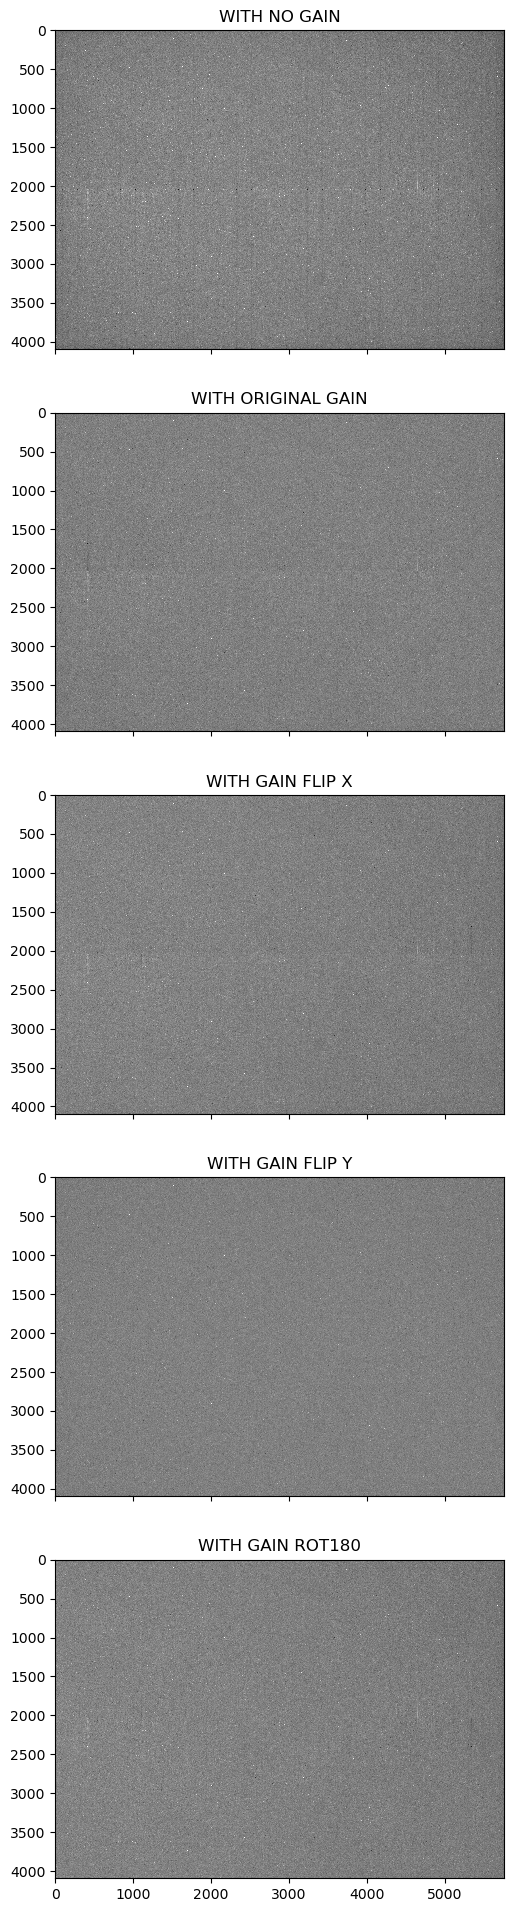

In [8]:
fig, axs = plt.subplots(nrows=5,ncols=1, sharex=True, sharey=True,figsize=(12,24))
axs[0].imshow(array_none-np.mean(array_none)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) 
axs[0].set_title('WITH NO GAIN')
axs[1].imshow(array_gain-np.mean(array_gain)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.45, 0.7)
axs[1].set_title('WITH ORIGINAL GAIN')
axs[2].imshow(array_gainflr-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[2].set_title('WITH GAIN FLIP X')
axs[3].imshow(array_gainfud-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[3].set_title('WITH GAIN FLIP Y')
axs[4].imshow(array_gainrot-np.mean(array_gainrot)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[4].set_title('WITH GAIN ROT180')


#plt.savefig("compare_brem_relion_sean_gaincorrection.pdf", format="pdf", bbox_inches="tight")

In [9]:
a = tifffile.imread(mic_list[10])

In [10]:
a.shape

(49, 4092, 5760)